In [1]:
from astropy.table import Table, vstack
from pathlib import Path
import matplotlib.pyplot as plt
import pickle
import seaborn as sns
import numpy as np
import pandas as pd

In [7]:
pub_res_tab = Table.read("/home/nmearl/research/tde_agn_comparison/pub_results.txt", format='ascii')
pub_objs_tab = Table.read("/home/nmearl/research/tde_agn_comparison/pub_objs.txt", format='ascii')

In [8]:
pub_objs_tab.pprint_all()

    ZTF      RAh RAm  RAs   DE- DEd  DEm    DEs     z     logAmp  E_logAmp e_logAmp  PL E_PL e_PL  Turn  E_Turn e_Turn   E1   e_E1   E2   e_E2  RACS  e_RACS f_RACS
              h  min   s        deg arcmin arcsec        dex(---) dex(---) dex(---)               1 / yr 1 / yr 1 / yr  mJy   mJy   mJy   mJy   mJy    mJy         
------------ --- --- ------ --- --- ------ ------ ------ -------- -------- -------- --- ---- ---- ------ ------ ------ ------ ---- ------ ---- ------ ------ ------
ZTF18aaaotwe  13  13 10.376  --  15     45  3.347 0.0657     -2.8      0.3      0.3 4.2  1.7  2.4    3.2    1.6    2.0     --   --     --   --     --     --     --
ZTF18aaaovpz  10  39  13.82  --   9     40  2.779  0.217     -2.8      0.4      0.7 2.2  3.3  1.0    0.3    1.1    0.3     --   --     --   --     --     --     --
ZTF18aaavwka  12  35 44.246  --  16      5 35.978 0.0711     -2.5      0.0      0.1 2.5  3.4  2.4   68.0   28.1   46.4     --   --     --   --     --     --     --
ZTF18aabkubl  11

In [9]:
pmap = {
'ZTF': 'label',
 'xi1': 'halpha_disk_inner_radius',
 'E_xi1': 'halpha_disk_inner_radius_up_err',
 'e_xi1': 'halpha_disk_inner_radius_lo_err',
 'xi2': 'halpha_disk_outer_radius',
 'E_xi2': 'halpha_disk_outer_radius_up_err',
 'e_xi2': 'halpha_disk_outer_radius_lo_err',
 'sigma': 'halpha_disk_sigma',
 'E_sigma': 'halpha_disk_sigma_up_err',
 'e_sigma': 'halpha_disk_sigma_lo_err',
 'i': 'halpha_disk_inclination',
 'E_i': 'halpha_disk_inclination_up_err',
 'e_i': 'halpha_disk_inclination_lo_err',
 'q': 'halpha_disk_q',
 'E_q': 'halpha_disk_q_up_err',
 'e_q': 'halpha_disk_q_lo_err',
 'phi': 'halpha_disk_apocenter',
 'E_phi': 'halpha_disk_apocenter_up_err',
 'e_phi': 'halpha_disk_apocenter_lo_err',
}

pub_res_tab.rename_columns(list(pmap.keys()), list(pmap.values()))
pub_res_tab['source'] = 'panic'
pub_res_tab['halpha_disk_inclination'] = np.deg2rad(pub_res_tab['halpha_disk_inclination'])
pub_res_tab['halpha_disk_apocenter'] = np.deg2rad(pub_res_tab['halpha_disk_apocenter'])
pub_res_tab = pub_res_tab[list(pmap.values()) + ['source']]
pub_res_tab = pub_res_tab[[x for x in pub_res_tab.colnames if 'err' not in x]]
pub_res_df = pub_res_tab.to_pandas()

In [16]:
results_dir = "/home/nmearl/research/tde_agn_comparison/results"

full_tab = None

for path in Path(results_dir).iterdir():
    label = path.stem

    if not (path / "disk_param_results.csv").exists():
        continue

    if full_tab is None:
        full_tab = Table.read(path / "disk_param_results.csv")
    else:
        tab = Table.read(path / "disk_param_results.csv")
        full_tab = vstack([full_tab, tab])

    # tab = Table.read(path / f"{label}" / "disk_param_results.csv")

full_tab['z'] = 0

for label in full_tab['label']:
    full_tab['z'][full_tab['label'] == label] = pub_objs_tab['z'][pub_objs_tab['ZTF'] == label]

full_tab['mjd'] = list(range(len(full_tab)))

df = full_tab.to_pandas()

In [22]:
pdf = df.pivot(index='label', columns='param', values='value')
pdf['r_hat'] = df.groupby('label')['r_hat'].mean().apply(lambda x: 0.99 <= x <= 1.01)
pdf['source'] = 'local'
pdf["mjd"] = df.groupby("label")["mjd"].first().values
pdf["type"] = "agn"

z_vals = [np.mean(pub_objs_tab['z'][pub_objs_tab['ZTF'] == label]) for label in pdf.index]

pdf['z'] = z_vals

In [18]:
pdf

param,halpha_disk_apocenter,halpha_disk_center,halpha_disk_delta_radius,halpha_disk_eccentricity,halpha_disk_inclination,halpha_disk_inner_radius,halpha_disk_offset,halpha_disk_outer_radius,halpha_disk_q,halpha_disk_scale,...,siil_narrow_center,siil_narrow_vel_width,siir_narrow_amplitude,siir_narrow_center,siir_narrow_vel_width,white_noise,r_hat,source,mjd,z
label,,,,,,,,,,,,,,,,,,,,,
ZTF18aaaotwe,2.306320,6565.260328,2793.953859,0.578624,0.187354,3236.852032,0.0,6151.146172,3.027271,0.212785,...,6717.974448,473.929037,0.106622,6732.578256,473.929037,-6.730308,True,local,0,0.0657
ZTF18aaaovpz,2.243085,6565.330392,2135.926894,0.812300,0.263210,195.615618,0.0,2341.539811,3.529784,0.148559,...,6716.680014,1119.191364,0.026686,6733.825927,1119.191364,-4.952607,True,local,28,0.2170
ZTF18aaavwka,0.186752,6564.126821,8212.343202,0.560447,0.424244,323.726222,0.0,8539.623560,0.574101,1.700768,...,6718.077800,322.904550,0.181940,6732.407009,322.904550,-7.493111,True,local,56,0.0711
ZTF18aabkubl,3.563124,6563.396893,7415.920298,0.514965,0.258352,136.537032,0.0,7575.110101,0.963259,0.111894,...,6715.292932,674.882463,0.258839,6731.596236,674.882463,-7.099281,True,local,84,0.1330
ZTF18aabylvn,4.665557,6566.891195,1151.180987,0.976701,0.738435,3624.191748,0.0,4967.152918,0.772770,13.034481,...,6721.299723,572.223516,3.045977,6735.678064,572.223516,-2.083150,True,local,112,0.0163
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ZTF20aalyhuc,1.787622,6564.485218,8925.116834,0.642196,0.253263,122.584195,0.0,9045.630322,1.140984,0.159615,...,6718.459580,378.296172,0.216741,6732.109586,378.296172,-2.896538,True,local,6328,0.0712
ZTF20aamaqmq,2.574901,6566.913128,3291.390477,0.284765,0.626840,3360.244005,0.0,6695.775250,1.383545,0.222998,...,6715.365502,504.008499,0.044056,6733.669215,504.008499,-7.043694,True,local,6356,0.3220
ZTF20aaosbad,2.077326,6565.129943,2777.765889,0.626417,0.208017,3297.533183,0.0,6172.998938,3.075384,0.252321,...,6716.427452,579.229823,0.021800,6731.441425,579.229823,-6.795333,True,local,6384,0.3100


In [2]:
tde_results_dir = "/home/nmearl/research/tde_agn_comparison/tde_results"

tde_full_tab = None

for path in Path(tde_results_dir).iterdir():
    label = path.stem

    if not (path / "disk_param_results.csv").exists():
        continue

    if tde_full_tab is None:
        tde_full_tab = Table.read(path / "disk_param_results.csv")
    else:
        tab = Table.read(path / "disk_param_results.csv")
        tde_full_tab = vstack([tde_full_tab, tab])

    # tab = Table.read(path / f"{label}" / "disk_param_results.csv")

tde_full_tab['z'] = 0

# for label in tde_full_tab['label']:
#     tde_full_tab['z'][tde_full_tab['label'] == label] = pub_objs_tab['z'][pub_objs_tab['ZTF'] == label]

tdf = tde_full_tab.to_pandas()
tdf

,label,mjd,redshift,param,value,err_lo,err_hi,n_eff,r_hat,z
0,ASASSN-14li,56994,0.0206,halpha_disk_apocenter,3.243305,1.031525,2.027431,118.057901,1.000501,0
1,ASASSN-14li,56994,0.0206,halpha_disk_center,6561.269772,0.821093,1.072929,549.285925,1.000218,0
2,ASASSN-14li,56994,0.0206,halpha_disk_delta_radius,53459.830860,2131.265916,8190.164976,120.985481,1.009689,0
3,ASASSN-14li,56994,0.0206,halpha_disk_eccentricity,0.001719,0.001291,0.005998,109.876528,1.001900,0
4,ASASSN-14li,56994,0.0206,halpha_disk_inclination,0.987963,0.009367,0.012156,1056.043122,1.000054,0
...,...,...,...,...,...,...,...,...,...,...
359,TDE2018zr,58256,0.0750,halpha_disk_outer_radius,1867.071763,683.202792,742.041365,1469.736635,1.000036,0
360,TDE2018zr,58256,0.0750,halpha_disk_q,0.736122,0.162674,0.228731,1921.388200,1.000243,0
361,TDE2018zr,58256,0.0750,halpha_disk_scale,0.136535,0.022991,0.026323,1153.743254,0.999933,0
362,TDE2018zr,58256,0.0750,halpha_disk_sigma,858.792046,611.507636,2294.617699,667.087670,1.000921,0


In [21]:
tpdf = tdf.pivot(index='mjd', columns='param', values='value')
# Add the 'label' column (since it's the same for each mjd, we take the first occurrence)
tpdf["label"] = tdf.groupby("mjd")["label"].first().values
tpdf["type"] = "tde"

In [24]:
full_pdf = pd.concat([pdf, tpdf])
full_pdf

param,halpha_disk_apocenter,halpha_disk_center,halpha_disk_delta_radius,halpha_disk_eccentricity,halpha_disk_inclination,halpha_disk_inner_radius,halpha_disk_offset,halpha_disk_outer_radius,halpha_disk_q,halpha_disk_scale,...,mjd,type,z,halpha_broad_amplitude,halpha_broad_center,halpha_broad_vel_width,hei_narrow_amplitude,hei_narrow_center,hei_narrow_vel_width,label
ZTF18aaaotwe,2.306320,6565.260328,2793.953859,0.578624,0.187354,3236.852032,0.0,6151.146172,3.027271,0.212785,...,0.0,agn,0.0657,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ZTF18aaaovpz,2.243085,6565.330392,2135.926894,0.812300,0.263210,195.615618,0.0,2341.539811,3.529784,0.148559,...,28.0,agn,0.2170,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ZTF18aaavwka,0.186752,6564.126821,8212.343202,0.560447,0.424244,323.726222,0.0,8539.623560,0.574101,1.700768,...,56.0,agn,0.0711,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ZTF18aabkubl,3.563124,6563.396893,7415.920298,0.514965,0.258352,136.537032,0.0,7575.110101,0.963259,0.111894,...,84.0,agn,0.1330,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ZTF18aabylvn,4.665557,6566.891195,1151.180987,0.976701,0.738435,3624.191748,0.0,4967.152918,0.772770,13.034481,...,112.0,agn,0.0163,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
58539,3.282576,6563.164588,25330.201860,0.219750,0.472484,460.845048,NaN,25912.465721,2.004309,0.100309,...,NaN,tde,NaN,0.080330,6563.164588,18939.475209,NaN,NaN,NaN,TDE2018hyz
58559,3.136608,6563.216537,30972.385277,0.207512,0.481293,494.584994,NaN,31596.676427,1.938239,0.064097,...,NaN,tde,NaN,0.046981,6563.216537,18092.314730,NaN,NaN,NaN,TDE2018hyz
58599,3.436597,6563.010288,8931.805109,0.476609,0.642769,1000.572567,NaN,10346.488962,2.127368,0.018365,...,NaN,tde,NaN,0.023495,6563.010288,12426.568491,NaN,NaN,NaN,TDE2018hyz
58617,2.838954,6562.935924,7311.452465,0.432580,0.883262,494.950557,NaN,8389.203211,1.576599,0.014952,...,NaN,tde,NaN,0.022534,6562.935924,5226.340977,NaN,NaN,NaN,TDE2018hyz


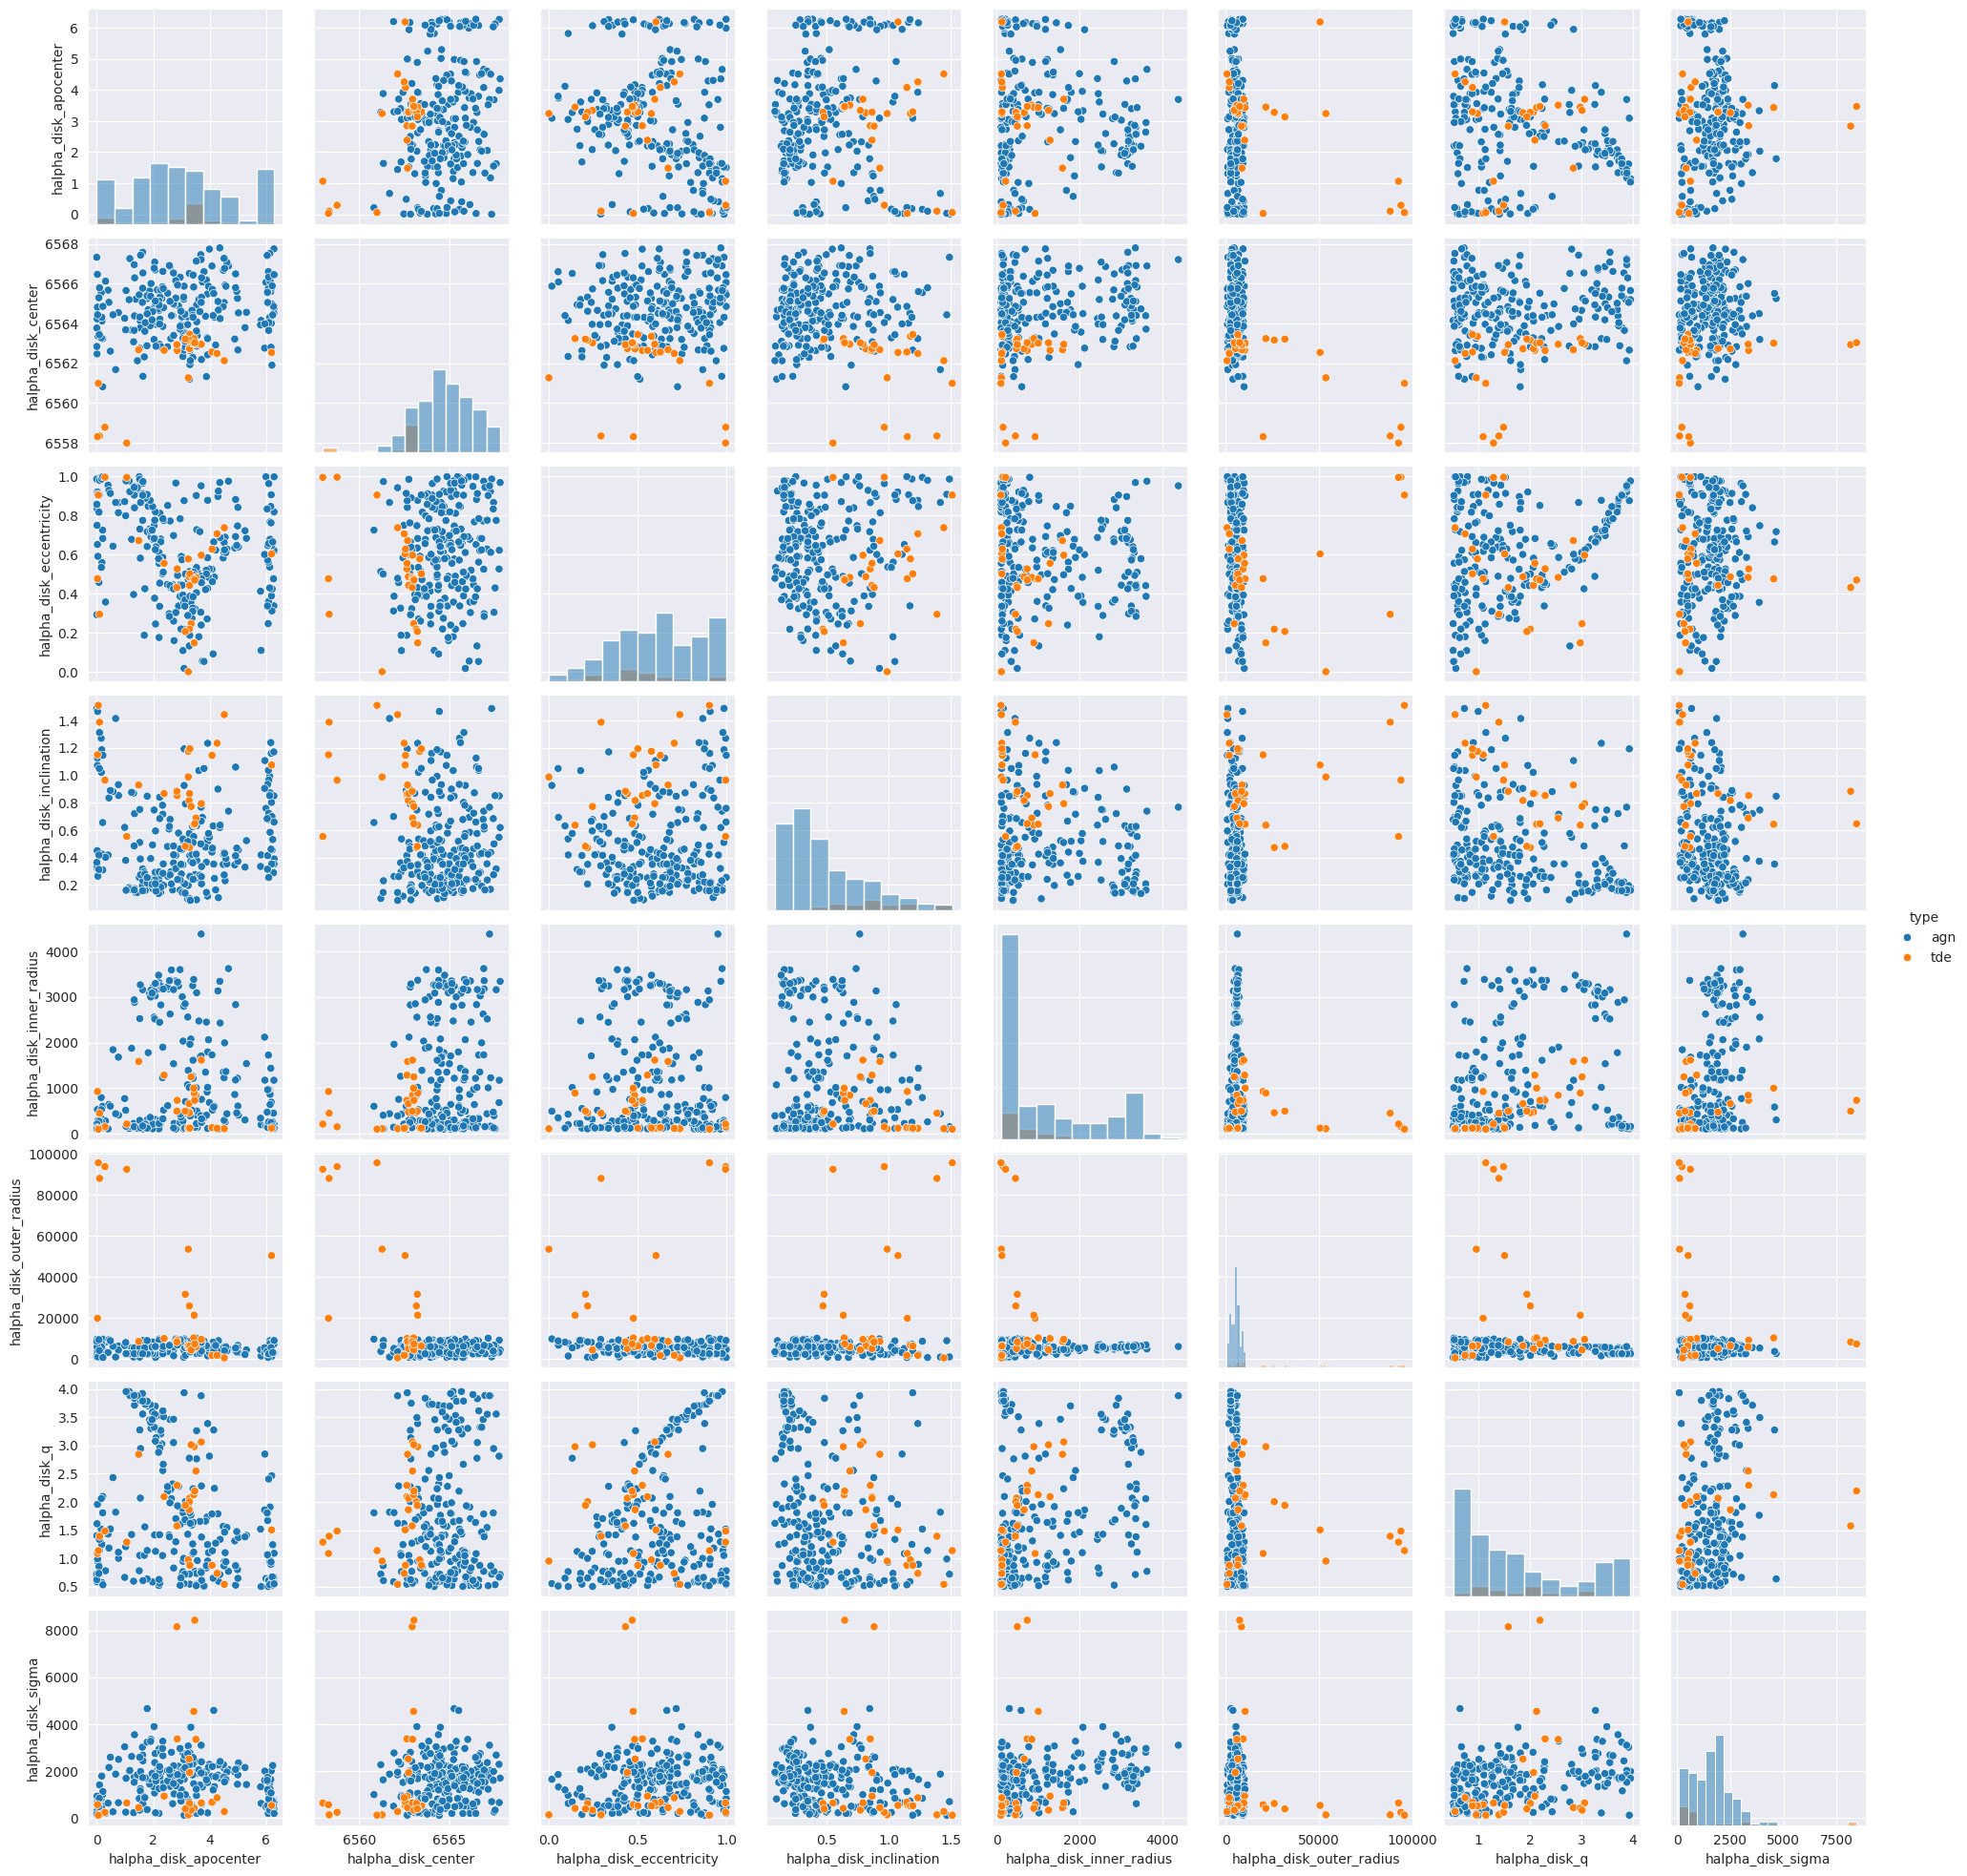

In [25]:
vars = list(set(df['param']))

g = sns.pairplot(
    full_pdf,
    x_vars=[x for x in full_pdf.columns if x.startswith("halpha_disk") and x not in [
        'halpha_disk_offset', 'halpha_disk_scale', 'halpha_disk_delta_radius', 
        # 'halpha_disk_center', 'halpha_disk_eccentricity'
    ] and not x.endswith("_flux")],
    y_vars=[x for x in full_pdf.columns if x.startswith("halpha_disk") and x not in [
        'halpha_disk_offset', 'halpha_disk_scale', 'halpha_disk_delta_radius', 
        # 'halpha_disk_center', 'halpha_disk_eccentricity'
    ] and not x.endswith("_flux")],
    diag_kind='hist',
    hue='type'
)
# g.map_lower(sns.kdeplot, levels=4, color=".2")
# g.map_upper(sns.kdeplot, levels=4, color=".2")
